In [11]:
#
from qutip import *
from numpy import real, cos, sin, exp, linspace,arccos, array, sqrt,pi
width = 3.45 #W
height = width #H (Or golden ratio)
import numpy as np
#The preamble of the text is:
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 2.5, "ytick.major.size": 0, "xtick.direction": "in"})

cmap = sns.color_palette(n_colors=10)
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
from tqdm import tqdm
from scipy.fft import fft, fftfreq



#
Iz = 0.5*sigmaz()
Ix = 0.5*sigmax()
Iy = 0.5*sigmay()
Ie = qeye(2)*0.5

C:\Users\majid\AppData\Local\Temp\ipykernel_14648\3479435540.py:9: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  mpl.use('pdf')


In [2]:
def five_pulse_ESEEM(azz, azx, tau1, tau2, Tc, N=1): # N = number of pi pulses at each hahn-echo, tau-2tau-2tau-2tau-...
    H0 = (WL-azz/2)*Iz-azx/2*Ix
    H1 = (WL+azz/2)*Iz+azx/2*Ix
    u0 = ((-1j*H1*tau1).expm())*((-1j*H0*tau1).expm())
    u1 = ((-1j*H0*tau1).expm())*((-1j*H1*tau1).expm())
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    v0 = ((-1j*H1*tau2).expm())*((-1j*H0*tau2).expm())
    v1 = ((-1j*H0*tau2).expm())*((-1j*H1*tau2).expm())
    
    if N==1:
        tt1 = (v1*W0*u0*(u1.dag())*(W0.dag())*(v0.dag())).tr()
        tt2 = (v0*W0*u0*(u1.dag())*(W0.dag())*(v1.dag())).tr()
        tt3 = (v1*W1*u0*(u1.dag())*(W1.dag())*(v0.dag())).tr()
        tt4 = (v0*W1*u0*(u1.dag())*(W1.dag())*(v1.dag())).tr()
        return [tt1, tt2, tt3, tt4]
    else:
        U0 = (u0**(N%2)) * ((u1*u0)**(N//2))
        U1 = (u1**(N%2)) * ((u0*u1)**(N//2))
        V0 = (v0**(N%2)) * ((v1*v0)**(N//2))
        V1 = (v1**(N%2)) * ((v0*v1)**(N//2))
        tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
        tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
        tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
        tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
        return [tt1, tt2, tt3, tt4]

def anal_eseem_spin_half(fL, Azz, Azx, tau1, tau2, tc): ## Azz and Azx are np.array
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+Azz/2)**2+(Azx/2)**2) ## specific for spin 1/2
    Ome_b = 2*pi*np.sqrt((FL-Azz/2)**2+(Azx/2)**2) ## specific for spin 1/2
    Ome_plus = Ome_a + Ome_a
    Ome_minu = Ome_b - Ome_b
    Eta_a = np.arctan((Azx/2)/(fL+Azz/2))     ## specific for spin 1/2
    Eta_b = np.arctan((-Azx/2)/(fL-Azz/2))    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    term1 = 1
    term2 = 1
    term3 = 1
    term4 = 1
    for i, azz in enumerate(Azz):
        E_2p_tau1 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau1) +cos(Ome_b[i]*tau1) 
                                  -0.5*cos(Ome_minu[i]*tau1) -0.5*cos(Ome_plus[i]*tau1))
        E_2p_tau2 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau2) +cos(Ome_b[i]*tau2) 
                                  -0.5*cos(Ome_minu[i]*tau2) -0.5*cos(Ome_plus[i]*tau2))

        term1 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term2 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term3 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) ) 
        
        term4 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) )
    
    
    signal = term1 - term2 + term3 -term4
    return [ signal, term1 , term2, term3, term4]

# Analytical is only for N=1 but it is faster 

Freq Larmor=63.0 kHz
Azz=[204.   -51.5   85.51   3.     4.  ] kHz
Azx=[ 64.4  143.6  120.11   5.     2.  ] kHz
Freq hyp up=[168.11258133  80.88759176 121.6171166   64.54843143  65.00769185] kHz
Freq hyp dn=[ 50.57509268 114.15692051  63.3755714   61.55079203  61.00819617] kHz
Blind Spot up=[ 5.94839477 12.36283561  8.2225268  15.49224323 15.38279504] us
Blind Spot dn=[19.77257869  8.7598719  15.77895044 16.24674463 16.39124024] us
k=[0.22770839 0.95989047 0.9638429  0.00628612 0.00100933] kHz


<IPython.core.display.Javascript object>


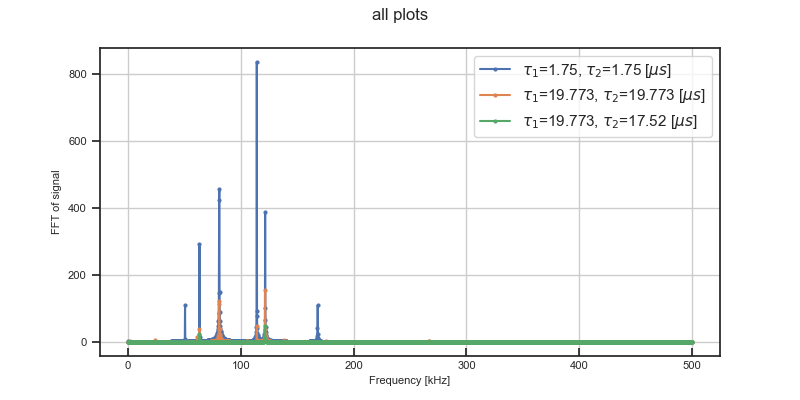

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5195.27it/s]


<IPython.core.display.Javascript object>


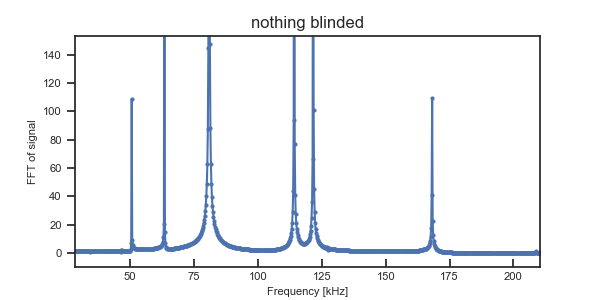

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5035.19it/s]


<IPython.core.display.Javascript object>


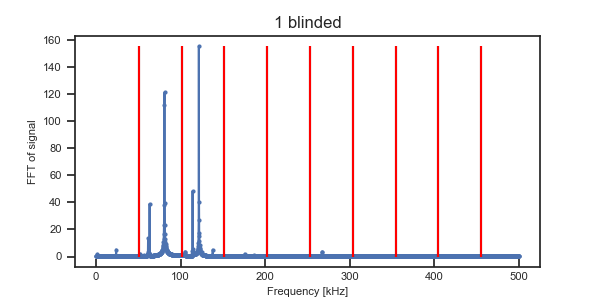

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5042.41it/s]


<IPython.core.display.Javascript object>


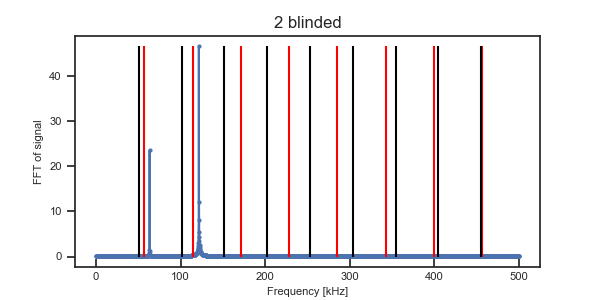

In [15]:
%matplotlib notebook
# determining the parameters
B = 63/1.07 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 85.51, 3, 4]) # kHz
Azx = np.array([64.4, 143.6, 120.11, 5, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz/2)**2+(Azx/2)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz/2)**2+(Azx/2)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k = (Azx*fL / (Fh_dn*Fh_up))**2
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k={} kHz'.format(k))


dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 5000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,1, figsize=(8, 4), dpi=100)

for tau1, tau2,txt in [[1.75e-3, 1.75e-3, 'nothing blinded'],[1*BS_dn[0], 1*BS_dn[0], '1 blinded']
                      ,[1*BS_dn[0], 2*BS_dn[1], '2 blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_half(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,1, figsize=(6, 3),dpi=100)
    ax.set_title(txt)
    ax.plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    for i in np.arange(1,50,1):
        if i/tau1 <np.max(freqs):ax.vlines(x=i/tau1,ymin=0,ymax=max(FFT_Signal),color='black')
        if i/tau2 <np.max(freqs):ax.vlines(x=i/tau2,ymin=0,ymax=max(FFT_Signal),color='red')
    ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    



fig_all.suptitle('all plots')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend(loc='upper right')
ax_all.grid()

# one strong nuclear spin

In [5]:
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([-204]) # kHz
Azx = np.array([64.4]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz/2)**2+(Azx/2)**2) # kHz
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz/2)**2+(Azx/2)**2) # kHz
BS_up = 1/Fh_up # in ms
BS_dn = 1/Fh_dn # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

Freq Larmor=64.2 kHz
Azz=[-204] kHz
Azx=[64.4] kHz
Freq hyp up=[49.65561398] kHz
Blind Spot up=[0.02013871] ms
Freq hyp dn=[169.29051952] kHz
Blind Spot dn=[0.00590701] ms


Freq Larmor=63.0 kHz
Azz=[204.   -51.5   85.51   3.     4.  ] kHz
Azx=[ 64.4  143.6  120.11   5.     2.  ] kHz
Freq hyp up=[168.11258133  80.88759176 121.6171166   64.54843143  65.00769185] kHz
Blind Spot up=[0.00594839 0.01236284 0.00822253 0.01549224 0.0153828 ] ms
Freq hyp dn=[ 50.57509268 114.15692051  63.3755714   61.55079203  61.00819617] kHz
Blind Spot dn=[0.01977258 0.00875987 0.01577895 0.01624674 0.01639124] ms


<IPython.core.display.Javascript object>


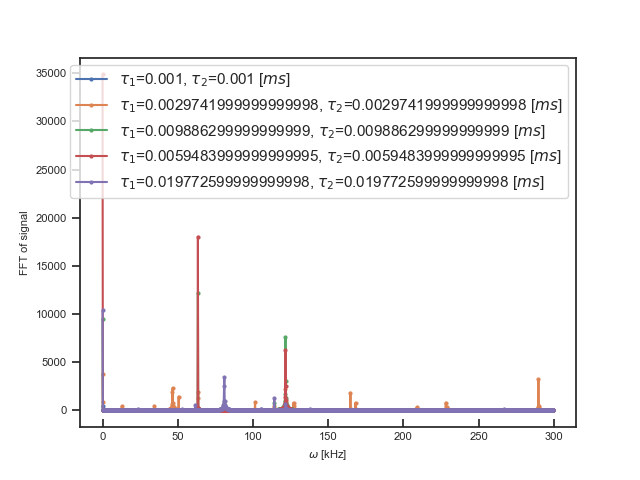

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:26<00:00, 34.87it/s]


<IPython.core.display.Javascript object>


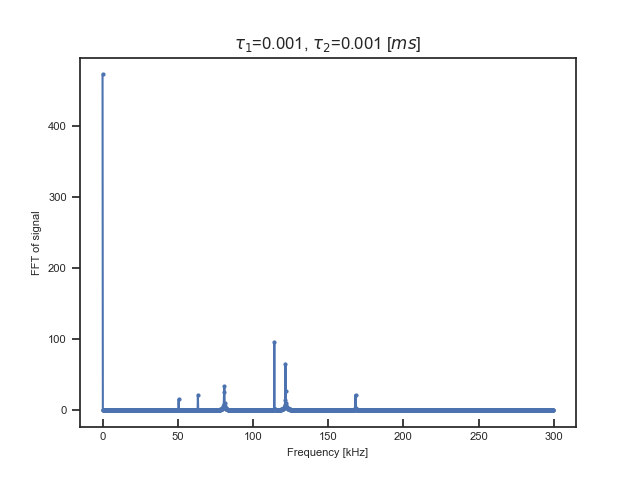

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:26<00:00, 34.86it/s]


<IPython.core.display.Javascript object>


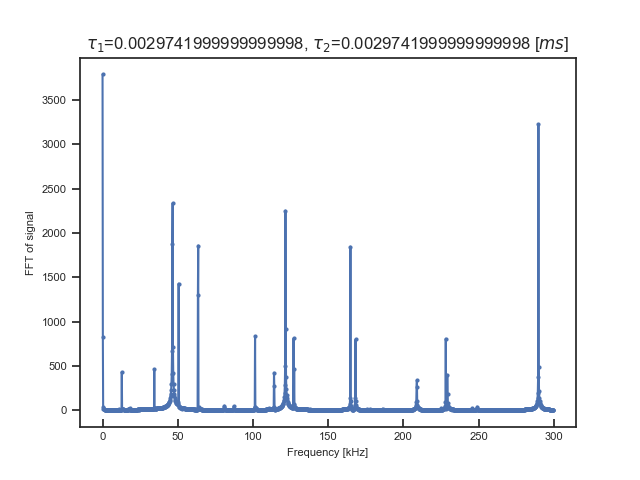

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:27<00:00, 34.18it/s]


<IPython.core.display.Javascript object>


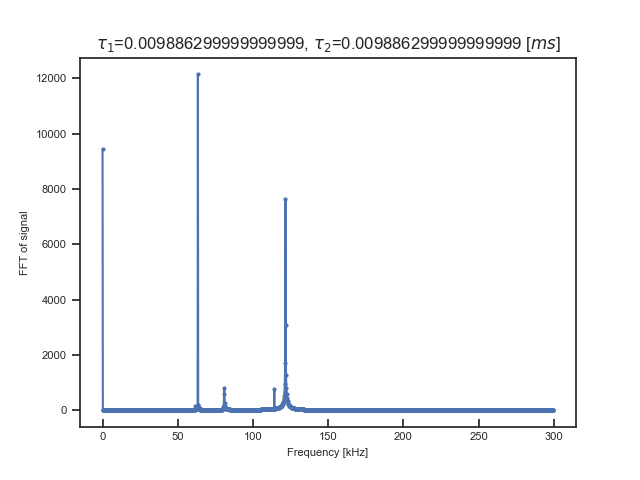

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:27<00:00, 34.26it/s]


<IPython.core.display.Javascript object>


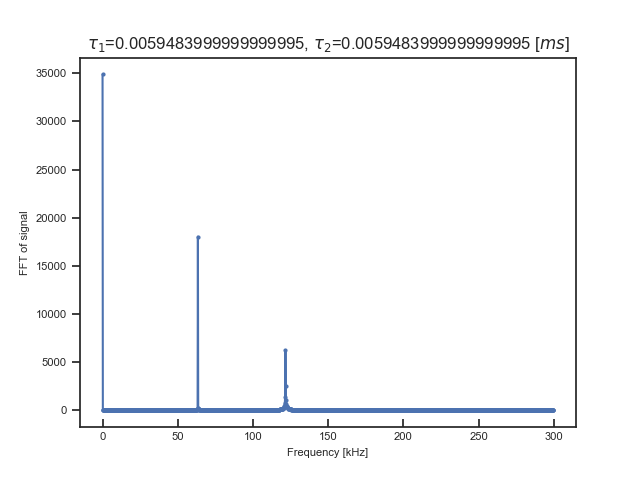

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:30<00:00, 33.06it/s]


<IPython.core.display.Javascript object>


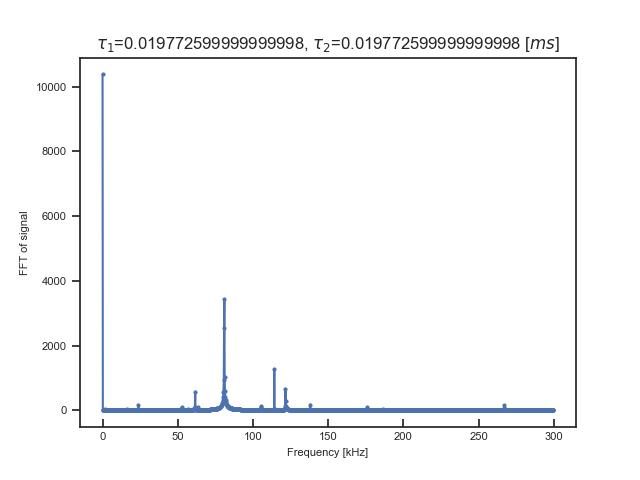

In [16]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots()
for tau1 in [0.001, 0.5*BS_up[0], 0.5*BS_dn[0], BS_up[0], BS_dn[0]]:
    tau2=tau1
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N=3)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)


    fig,ax = plt.subplots()
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

# Two strong nuclear spin

In [ ]:
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([-204, 51.5]) # kHz
Azx = np.array([64.4, 143.6]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz/2)**2+(Azx/2)**2) # kHz
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz/2)**2+(Azx/2)**2) # kHz
BS_up = 1/Fh_up # in ms
BS_dn = 1/Fh_dn # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1 in [0.001, 0.5*BS_up[0], 0.5*BS_dn[1], BS_up[0], BS_dn[1]]:
    tau2=tau1
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)


    fig,ax = plt.subplots(dpi=150)
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

# Three Nuclear Spin

In [ ]:
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([-204, 51.5, 3]) # kHz
Azx = np.array([64.4, 143.6, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz/2)**2+(Azx/2)**2) # kHz
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz/2)**2+(Azx/2)**2) # kHz
BS_up = 1/Fh_up # in ms
BS_dn = 1/Fh_dn # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2 in [[0.25*BS_up[0],0.25*BS_up[0]], [BS_dn[0],0.5*BS_up[2]], [0.5*BS_up[2],BS_dn[1]], [BS_up[0],BS_up[1]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=150)
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

# Four Nuclear Spin

In [ ]:
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([-204, 51.5, 3, 1]) # kHz
Azx = np.array([64.4, 143.6, 2, 1]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz/2)**2+(Azx/2)**2) # kHz
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz/2)**2+(Azx/2)**2) # kHz
BS_up = 1/Fh_up # in ms
BS_dn = 1/Fh_dn # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2 in [[0.25*BS_up[0],0.25*BS_up[0]], [BS_dn[0],0.5*BS_up[3]], [0.5*BS_up[3],BS_up[1]], [BS_up[0],BS_up[1]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=150)
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2 in [[(121*BS_up[1]+101*BS_up[0])/2, 0.5*BS_up[2]],[(121*BS_up[1]+101*BS_up[0])/2, 0.5*BS_up[3]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=150)
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [ ]:
integers = np.arange(1000)
residual =[]
for i in integers:
    residual.append((BS_up[2]*i)%BS_up[0])

fig,ax = plt.subplots(dpi=150)
ax.plot(integers, residual,'-o',markersize=2, alpha = 1)
(BS_up[2]*45)/BS_up[0]

In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} ms'.format(BS_dn))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2 in [[BS_up[1], 34*BS_up[0]],[BS_up[1], 33*BS_up[0]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=150)
    plt.title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$ms$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()